In [1]:
from keras.models import Sequential  
from keras.layers.core import Dense, Activation, Dropout, TimeDistributedDense,Flatten
from keras.layers.recurrent import LSTM
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD,Adadelta,RMSprop
from keras.layers.embeddings import Embedding
from keras.layers import Merge
import pandas as pd  
from random import random
import numpy as np
import talib as ta
from datetime import datetime
from pandas.io import data, wb
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import preprocessing
import urllib2
import pytz
from bs4 import BeautifulSoup
import copy
import csv
import urllib2
import datetime as dt
import matplotlib.pyplot as plt

Using Theano backend.
Using gpu device 0: GeForce GTX 980 Ti (CNMeM is disabled, cuDNN 4007)
/home/ai2-jedi/anaconda2/lib/python2.7/site-packages/pandas/io/data.py:33: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)
/home/ai2-jedi/anaconda2/lib/python2.7/site-packages/pandas/io/wb.py:19: FutureWarning: 
The pandas.io.wb module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)
/home/ai2-jedi/anaconda2/lib/py

In [2]:
SITE = "http://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
def scrape_list(site):
    hdr = {'User-Agent': 'Mozilla/5.0'}
    req = urllib2.Request(site, headers=hdr)
    page = urllib2.urlopen(req)
    soup = BeautifulSoup(page)

    table = soup.find('table', {'class': 'wikitable sortable'})
    sector_tickers = dict()
    for row in table.findAll('tr'):
        col = row.findAll('td')
        if len(col) > 0:
            sector = str(col[3].string.strip()).lower().replace(' ', '_')
            ticker = str(col[0].string.strip())
            if sector not in sector_tickers:
                sector_tickers[sector] = list()
            sector_tickers[sector].append(ticker)
    return sector_tickers
sector_tickers = scrape_list(SITE)

##Help functions to normalize and denormalize values
def normalize(x):
    merged = []
    for attr in x:
        for val in attr:
            merged.append(val)
    mn = min(merged)
    mx = max(merged)
    for attr in range(len(x)):
        for val in range(len(x[attr])):
            x[attr][val] = (x[attr][val]-mn) / (mx-mn)
    return x, mn, mx

def deNormalizeY(y,mn,mx):
    for val in range(len(y)):
        y[val] = (y[val]*(mx-mn) + mn)
    return y

##Help functions to put each sequence in its own normal distribution
def normDist(x):
    mean = x.mean()
    std = x.std()
    x_norm = (x - mean)/std
    #x_norm = toBins(x_norm)
    return x_norm, mean, std

def deNormDist(y_norm,mean,std):
    y = (y_norm*std)+mean
    return y

/home/ai2-jedi/anaconda2/lib/python2.7/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


In [3]:
# Sequence Length, or # of days of trading
SEQ_LENGTH = 25

# Number of units in the two hidden (LSTM) layers
N_HIDDEN = 256

#Number of attributes used for each trading day
num_attr = 4

#Out of those attribute how many are indicators
num_indicators = 0

#Variable to help define how far you want your y to reach
REWARD_LAG = 1

#How many dats ahead do you want to predict
LOOK_AHEAD = 5

#Window Stride
STRIDE = 1

In [4]:
def _load_data(data, n_prev = SEQ_LENGTH):  
    docX, docY = [], []
    for i in range(len(data)-n_prev):
        x,y = norm(data.iloc[i:i+n_prev,:num_attr].as_matrix(),data.iloc[i+n_prev-1,num_attr:].as_matrix())
        docX.append(x)
        docY.append(y)
    alsX = np.array(docX)
    alsY = np.array(docY)
    return alsX, alsY

def _load_data_test(data, n_prev = SEQ_LENGTH):  
    docX, docY = [], []
    num_sequences = (len(data)-n_prev+1)/STRIDE
    for i in range(num_sequences):
        i = i*STRIDE
        x = (data.iloc[i:i+n_prev,:num_attr].as_matrix())
        y = (data.iloc[i+n_prev-1,num_attr:].as_matrix())
        #x,y = norm(data.iloc[i:i+n_prev,:num_attr].as_matrix(),data.iloc[i+n_prev-1,num_attr:].as_matrix())
        docX.append(x)
        docY.append(y)
    alsX = np.array(docX)
    alsY = np.array(docY)
    return alsX, alsY

def _load_data_norm(data, n_prev = SEQ_LENGTH):  
    docX, docY = [], []
    for i in range(len(data)-n_prev):
        x = np.array((data.iloc[i:i+n_prev,:num_attr].as_matrix()))
        y = np.array((data.iloc[i+n_prev-1,num_attr:].as_matrix()))
        
        mean = x.mean()
        std = x.std()
        
        x_norm = (x - mean)/std
        y_norm = (y - mean)/std
        
        docX.append(x_norm)
        docY.append(y_norm)
        
    alsX = np.array(docX)
    alsY = np.array(docY)

    return alsX, alsY

def _load_data_gaussian(data, n_prev = SEQ_LENGTH):  
    docX, docY = [], []
    num_sequences = (len(data)-n_prev+1)/STRIDE
    for i in range(num_sequences):
        i = i*STRIDE
        x = np.array((data.iloc[i:i+n_prev,:num_attr-num_indicators].as_matrix()))
        y = np.array((data.iloc[i+n_prev-1,num_attr:].as_matrix()))
        indicators = np.array((data.iloc[i:i+n_prev,num_attr-num_indicators:num_attr].as_matrix()))
        mean = x.mean()
        std = x.std()
        
        x_norm = (x - mean)/std
        y_norm = (y - mean)/std

        x_concat = []
        for i in range(len(x_norm)):
            toAdd = []
            day = x_norm[i]
            for x in day:
                toAdd.append(x)
            day = indicators[i]
            for x in day:
                toAdd.append(x)
            x_concat.append(toAdd)
            
            
        #x_concat = toBins(x_concat)
        
        docX.append(x_concat)
        #docY.append(y[0])
        docY.append(y_norm)
        
    alsX = np.array(docX)
    alsY = np.array(docY)

    return alsX, alsY

def toBins(seq):
    #print (seq)
    bins = []
    for day in seq:
        new_day = []
        for attr in day:
            if attr < -2:
                new_day.append(0)
            elif attr >= -2 and attr < -1:
                new_day.append(1)
            elif attr >= -1 and attr < -0:
                new_day.append(2)
            elif attr >= 0 and attr < 1:
                new_day.append(3)
            elif attr >= 1 and attr < 2:
                new_day.append(4)
            else:
                new_day.append(5)
        bins.append(new_day)
    return (bins)

def norm(x,y):
    merged = []
    output = []
    yOut = []
    xOut = []
    for attr in x:
        for val in attr:
            merged.append(val)
    for val in y:
        merged.append(val)
    #print (merged)
    
    for attr in range(len(x)):
        for val in range(len(x[attr])):
            x[attr][val] = (x[attr][val]-min(merged)) / (max(merged)-min(merged))
    #print (y)
    for val in range(len(y)):
        #print (y[val])
        y[val] = (y[val]-min(merged)) / (max(merged)-min(merged))
    return x,y

def DynamicRangeReduction(previous,current):
#     change = (current-previous)/previous
    change = (current/float(previous))-1

#     if (change < 0):
#         sign = -1
#     else:
#         sign = 1

#     DRR = sign * (math.log(abs(change)+.000001)+1)

    return change

def train_test_split(sliced_df, test_size=0.0):  
    """
    This just splits data to training and testing parts
    """
    ntrn = round(len(sliced_df) * (1 - test_size))
    X_train, y_train = _load_data_gaussian(sliced_df.iloc[0:ntrn])
    #X_test, y_test = _load_data_gaussian(sliced_df.iloc[ntrn:])

    #return (X_train, y_train), (X_test, y_test)
    return (X_train, y_train)

def train_test_split_intra(sliced_df, test_size=0.1):  
    """
    This just splits data to training and testing parts
    """
    ntrn = round(len(sliced_df) * (1 - test_size))
    X_train, y_train = _load_data_gaussian(sliced_df.iloc[0:ntrn])
    X_test, y_test = _load_data_test(sliced_df.iloc[ntrn:])

    return (X_train, y_train), (X_test, y_test)

## Create Forex Single Dataset

In [5]:
##Dataset on just single ticker to test performances
df = data.DataReader('EUR=X', 'yahoo', datetime(2010,8,1), datetime(2014,8,1))
# df['RSI'] = ta.RSI(df.Close.values,timeperiod=14)
# _,_, macdhist = ta.MACD(df.Close.values, fastperiod=12, slowperiod=26, signalperiod=9)
# df['MACDHist'] = macdhist

##Add the predicted coloumn Y, as the last coloumn can be defined however you think is a good representation of a good decision 
##Clean the rest of the Data Frame
y = []
for i in range(0,len(df)):
    if i >= (len(df)- STRIDE):
        y.append(None)
    else:
        if (REWARD_LAG > 1):
            val = 0
            for n in range(REWARD_LAG):
                val = val + df['Close'][i+n+1]
            val = val / float(REWARD_LAG)
            y.append(val)
        else:
            y.append(df['Close'][i+REWARD_LAG])

    
df['Y_Values'] =np.asarray(y)
df = df.dropna()
#print (df)
sliced_df = df.drop(['Adj Close','Volume'] ,axis=1)
#print (sliced_df)
#(X_train, y_train), (X_test, y_test) = train_test_split(sliced_df)
(X_train, y_train) = train_test_split(sliced_df)
print(X_train[0],y_train[0])
print (X_train.shape,y_train.shape)

(array([[-0.76244909, -0.75153814, -1.36800657, -1.28695383],
       [-1.28305706, -1.17005084, -1.66649887, -1.50673145],
       [-1.51062822, -1.11159935, -1.57219712, -1.50673145],
       [-1.21992945, -1.04535432, -1.55349264, -1.20668044],
       [-1.30487896, -1.21525333, -1.97044664, -1.31111378],
       [-1.77716703, -1.53400881, -1.85744042, -1.77560832],
       [-1.53322946, -0.85986824, -1.53322946, -1.52855334],
       [-1.33059761,  0.11120592, -1.33059761, -1.3274802 ],
       [ 0.25382756,  0.51179349, -0.17091996,  0.24135791],
       [ 0.31461712,  0.67234026, -0.03998862,  0.30838229],
       [ 0.59362558,  0.75651042,  0.1197788 ,  0.58894946],
       [ 0.38865568,  0.42450593, -0.07895628,  0.3933318 ],
       [ 0.08626661,  0.33176289, -0.11090976,  0.07223825],
       [ 0.18758254,  0.54530568, -0.02206349,  0.18290642],
       [ 0.40736016,  1.09630844,  0.29357458,  0.41203627],
       [ 0.87731017,  1.17580247,  0.79158131,  0.88120694],
       [ 1.2202256 ,  1

/home/ai2-jedi/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:142: FutureWarning: slice indexers when using iloc should be integers and not floating point


## Helper function to scrape Google Intraday data

In [6]:
def get_google_data(symbol, period, window):
    url_root = 'http://www.google.com/finance/getprices?i='
    url_root += str(period) + '&p=' + str(window)
    url_root += 'd&f=d,o,h,l,c,v&df=cpct&q=' + symbol
    print(url_root)
    response = urllib2.urlopen(url_root)
    data = response.read().split('\n')
    #actual data starts at index = 7
    #first line contains full timestamp,
    #every other line is offset of period from timestamp
    parsed_data = []
    anchor_stamp = ''
    end = len(data)
    for i in range(7, end):
        cdata = data[i].split(',')
        if 'a' in cdata[0]:
            #first one record anchor timestamp
            anchor_stamp = cdata[0].replace('a', '')
            cts = int(anchor_stamp)
        else:
            try:
                coffset = int(cdata[0])
                cts = int(anchor_stamp) + (coffset * period)
                parsed_data.append((dt.datetime.fromtimestamp(float(cts)), float(cdata[1]), float(cdata[2]), float(cdata[3]), float(cdata[4]), float(cdata[5])))
            except:
                pass # for time zone offsets thrown into data
    df = pd.DataFrame(parsed_data)
    df.columns = ['ts', 'Open', 'High', 'Low', 'Close', 'Volume']
    df.index = df.ts
    del df['ts']
    return df

## Create Single Intraday Dataset

/home/ai2-jedi/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:153: FutureWarning: slice indexers when using iloc should be integers and not floating point
/home/ai2-jedi/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:154: FutureWarning: slice indexers when using iloc should be integers and not floating point


http://www.google.com/finance/getprices?i=900&p=150d&f=d,o,h,l,c,v&df=cpct&q=AAPL
(1168, 108)


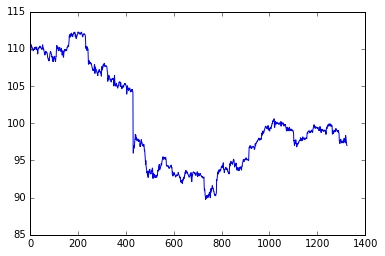

In [53]:
df = get_google_data('AAPL', 900, 150)
#print(df)
plt.plot(df['Close'].values[:])
y = []
for i in range(0,len(df)):
    if i >= (len(df)- REWARD_LAG):
        y.append(None)
    else:
        if (REWARD_LAG > 1):
            val = 0
            for n in range(REWARD_LAG):
                val = val + df['Close'][i+n+1]
            val = val / float(REWARD_LAG)
            y.append(val)
            print('here')

        else:
            y.append(df['Close'][i+REWARD_LAG])

    
df['Y_Values'] =np.asarray(y)
df = df.dropna()
sliced_df = df.drop(['Volume'] ,axis=1)
#print(sliced_df)
(X_train, y_train), (X_test, y_test) = train_test_split_intra(sliced_df)
#print(X_train[0],y_train[0])
print(len(X_train),len(X_test))
#print(X_test[0],y_test[0])

## Build your Network Structure

In [6]:
model_intra = Sequential() 

model_intra.add(LSTM(N_HIDDEN, return_sequences=True, activation='tanh', input_shape=(SEQ_LENGTH, num_attr)))
#model_intra.add(LSTM(N_HIDDEN, return_sequences=True, activation='tanh'))
model_intra.add(LSTM(N_HIDDEN, return_sequences=False, activation='tanh'))

model_intra.add(Dense(1,activation='linear'))
model_intra.compile(loss="mean_squared_error", optimizer='adam')

In [7]:
model_intra_full = Sequential() 

model_intra_full.add(LSTM(N_HIDDEN, return_sequences=True, activation='tanh', input_shape=(SEQ_LENGTH, num_attr)))
#model_intra_full.add(LSTM(N_HIDDEN, return_sequences=True, activation='tanh'))
model_intra_full.add(LSTM(N_HIDDEN, return_sequences=False, activation='tanh'))

model_intra_full.add(Dense(1,activation='linear'))
model_intra_full.compile(loss="mean_squared_error", optimizer='adam')

In [8]:
model_forex = Sequential() 

model_forex.add(LSTM(N_HIDDEN, return_sequences=True, activation='tanh', input_shape=(SEQ_LENGTH, num_attr)))
#model_forex.add(LSTM(N_HIDDEN, return_sequences=True, activation='tanh'))
model_forex.add(LSTM(N_HIDDEN, return_sequences=False, activation='tanh'))

model_forex.add(Dense(1,activation='linear'))
model_forex.compile(loss="mean_squared_error", optimizer='adam')

## Fit the model with your training data and parameters

In [9]:
print(X_train.shape)
print(y_train.shape)

(1018, 25, 4)
(1018, 1)


In [55]:
##Train the standard 2 layer LSTM on one ticker. Train one at a time as each can take awhile
model_intra.fit(X_train, y_train, batch_size=50, nb_epoch=150, validation_split=0.01)

##Train the standard 2 layer LSTM on one ticker. Train one at a time as each can take awhile
#model_forex.fit(X_train, y_train, batch_size=50, nb_epoch=100, validation_split=0.01)

##Train the standard 2 layer LSTM on all 500 tickers in S&P but for only 3 years each
#model_intra_full.fit(X_train_merged, y_train_merged, batch_size=1500, nb_epoch=30, validation_split=0.1)  

##Train the bidirectional 2 layer lstm on one ticker
#bimodel.fit([X_train_merged,X_train_merged], y_train_merged, batch_size=1500, nb_epoch=300, validation_split=0.3)

Train on 1156 samples, validate on 12 samples
Epoch 1/150
1156/1156 [==============================] - 1s - loss: 1.9575 - val_loss: 0.5494
Epoch 2/150
1156/1156 [==============================] - 1s - loss: 1.4731 - val_loss: 0.4006
Epoch 3/150
1156/1156 [==============================] - 1s - loss: 1.3794 - val_loss: 0.2988
Epoch 4/150
1156/1156 [==============================] - 1s - loss: 1.3115 - val_loss: 0.3101
Epoch 5/150
1156/1156 [==============================] - 1s - loss: 1.2994 - val_loss: 0.2682
Epoch 6/150
1156/1156 [==============================] - 1s - loss: 1.2778 - val_loss: 0.2616
Epoch 7/150
1156/1156 [==============================] - 1s - loss: 1.2881 - val_loss: 0.3635
Epoch 8/150
1156/1156 [==============================] - 1s - loss: 1.2643 - val_loss: 0.3308
Epoch 9/150
1156/1156 [==============================] - 1s - loss: 1.2520 - val_loss: 0.3220
Epoch 10/150
1156/1156 [==============================] - 1s - loss: 1.2615 - val_loss: 0.3088
Epoch 11/150


# Helper Performance Evaluation Functions

In [21]:
#Function to normalize the test input then denormalize the result. Calculate the rmse of the predicted values on the test set
def predict(X_test,y_test, myModel):
    predicted = []
    for example in X_test:
        x = copy.copy(example)
        #print (x)
        x_norm, mn, mx = normalize(x)
        toPred = []
        toPred.append(x_norm)
        add = np.array(toPred)
        #Predict for the standard model
        predict_standard = myModel.predict(add)
        pred_st = copy.copy(predict_standard)
        y_real_st = deNormalizeY(pred_st,mn,mx)
        predicted.append(y_real_st[0])

        #Predict for the bidirectional model
#         predict_bidirectional = myModel.predict([add,add])
#         pred_bi = copy.copy(predict_bidirectional)
#         y_real_bi = deNormalizeY(pred_bi,mn,mx)
#         predicted.append(y_real_bi[0])

    return predicted

def rmse(predicted,y_test):
    rmse = (((predicted - y_test) ** 2).mean(axis=0))**(1.0/2.0)
    #print ("The root mean squared error of this test set was " + str(rmse))
    return (rmse)

def predictNorm(X_test,y_test, myModel):
    predicted = []
    for example in X_test:
        x = copy.copy(example)
        x_norm, mean, std = normDist(x)
        toPred = []
        toPred.append(x_norm)
        add = np.array(toPred)
        
        #Predict for the standard model
#         predict_standard = myModel.predict(add)
#         pred_st = copy.copy(predict_standard)
#         y_real_st = deNormDist(pred_st,mean,std)
#         predicted.append(y_real_st[0])

        #Predict for the bidirectional model
        predict_bidirectional = myModel.predict([add,add])
        pred_bi = copy.copy(predict_bidirectional)
        y_real_bi = deNormDist(pred_bi,mean,std)
        predicted.append(y_real_bi[0])

    return predicted

def predict_change(X_test, y_test, myModel):
    predicted = []
    for example in X_test:
        toPred = []
        toPred.append(example)
        add = np.array(toPred)
        
        #Predict for the standard model
        predict_standard = myModel.predict(add)
        predicted.append(predict_standard[0])
        
        #predict_bidirectional = myModel.predict([add,add])
        #predicted.append(predict_bidirectional[0])
    return predicted


def predict_standard(X_test, y_test, myModel):
    predicted = []
    for example in X_test:
        seq_trans = []
        indicators = []
        
        for day in example:
            toAdd = [day[0],day[1],day[2],day[3]]
            #indiToAdd = [day[4],day[5]]
            seq_trans.append(toAdd)
            #indicators.append(indiToAdd)
            
        x_norm, mean, std = normDist(np.array(seq_trans))
        
        backTogetherSequence = []
        for i in range(len(x_norm)):
            toAdd = []
            day = x_norm[i]
            for x in day:
                toAdd.append(x)
            #day = indicators[i]
            #for x in day:
                #toAdd.append(x)
            backTogetherSequence.append(toAdd)
                
            
        toPred = []
        toPred.append(backTogetherSequence)
        add = np.array(toPred)
        
        #Predict for the standard model
        predict_standard = myModel.predict(add)
        pred_bi = copy.copy(predict_standard)
        y_real_bi = deNormDist(pred_bi,mean,std)
        predicted.append(y_real_bi[0])
        
        #Predict for the bidirectional model
#         predict_bidirectional = myModel.predict([add,add])
#         pred_bi = copy.copy(predict_bidirectional)
#         y_real_bi = deNormDist(pred_bi,mean,std)
#         predicted.append(y_real_bi[0])
        
    return predicted

def evaluation(predicted,y_test,THRESH):
        net_profit=0
        num_trades = 0
        for i in range(len(predicted)):
            if i>1:
                predicted_change = ((predicted[i] / y_test[i-1]) - 1)
                #print(predicted_change)
                actual_change = (predicted[i] -  y_test[i])*LOT_SIZE
                if predicted_change >= THRESH:
                    #print("Buy")
                    net_profit = net_profit + actual_change 
                    num_trades = num_trades + 1
                elif predicted_change <= -THRESH:
                    #print("Short")
                    net_profit = net_profit - actual_change
                    num_trades = num_trades + 1
                else:
                    #print("Do Nothing")
                    pass
        net_profits.append(net_profit)
        protits_per_trade.append(net_profit/float(num_trades))
        return net_profit,num_trades
    
##Backtesting evaluation function to see how sum of buying and selling on each time frames performs
def evaluation2(X_test,y_test,predicted_st,thresh):
    count = 0
    shortCount = 0
    longCount = 0
    netShort = 0
    netLong = 0
    loss = 0
    gain = 0
    for i in range(len(y_test)):
        closeOnLastDay = X_test[i][SEQ_LENGTH-1][3]
        percent_change = abs(predicted_st[i]-closeOnLastDay)/closeOnLastDay
        #lot_size = percent_change * 10000
        lot_size = 10000
        if( percent_change >= thresh):
            #print(percent_change,lot_size)
            count = count + 1
            #If greater than a 1% change was predicted in either direction take an action
            if(predicted_st[i]<closeOnLastDay):
                #If predicted is less than close of current day: Short
                shortCount = shortCount +1
                if(y_test[i]>closeOnLastDay):
                    #Case where you were incorrect and the stock went up after you shorted it
                    loss = (y_test[i]-closeOnLastDay)*lot_size
                    netShort = netShort - loss
                else:
                    #Case where the stock correctly goes down after you shorted it
                    gain = (closeOnLastDay-y_test[i])*lot_size
                    netShort = netShort + gain
            else:
                #If predicted is more than close of current day: Long
                longCount = longCount +1
                if(y_test[i]>closeOnLastDay):
                    #Case where the stock went up after you longed it
                    gain = (y_test[i]-closeOnLastDay)*lot_size
                    netLong = netLong + gain
                else:
                    #Case where the stock correctly goes down after you shorted it
                    loss = (closeOnLastDay-y_test[i])*lot_size
                    netLong = netLong - loss


    actionsPercentage = count / float(len(y_test))
    net = netLong + netShort
#     print ('You made ' + str(count) + ' trades')
#     print ('You made ' + str(shortCount) + ' Short trades and made ' + str(netShort))
#     print ('You made ' + str(longCount) + ' Long trades and made ' + str(netLong))
#     print('Decisions were made on ' + str(actionsPercentage*100) + "% of available days")
    print ('If you opened and closed a SCALED share position with these predictions per day your net is ' + str(net))
    return (net)
    
##Graph the predicted versus the actual
def graph(y_test,predicted):
    plt.figure(figsize=(15,15))
    plt.plot(y_test[:50])
    plt.plot(predicted[:50])
    plt.show()

## Run prediction on your test data for 1-Day Prediction

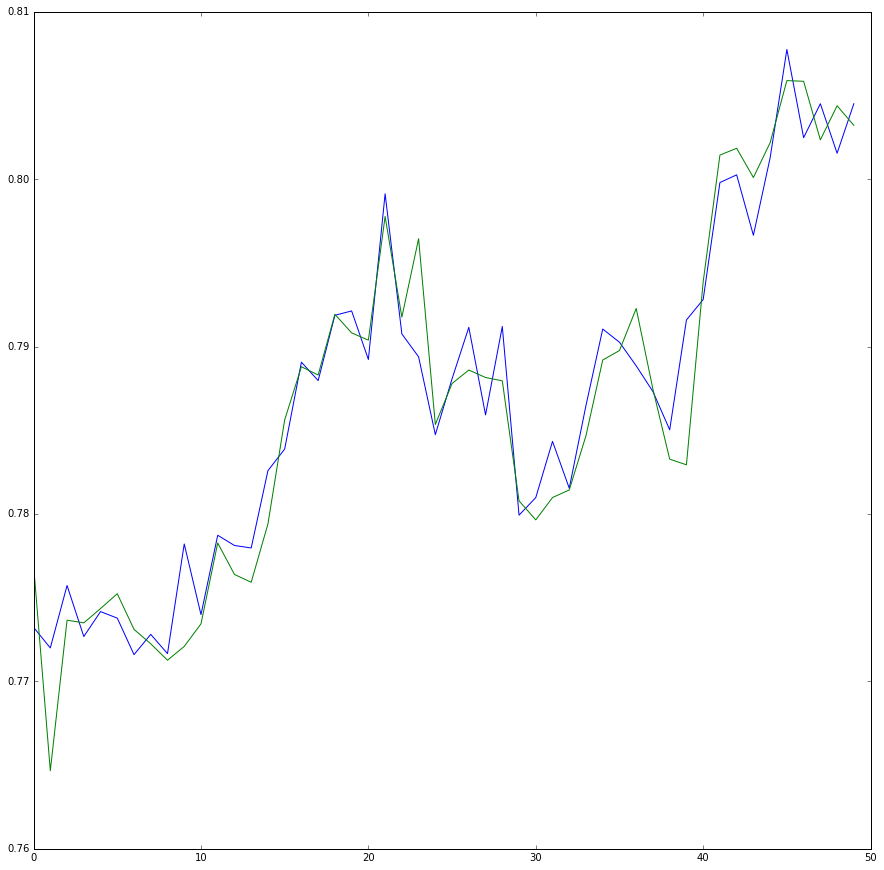

MAE for LSTM is: [0.0035823152701196983]
MAE for doing nothing is: [0.0045693478326778786]
RMSE for LSTM is: [0.0050684837061917686]
RMSE for doing nothing is: [0.0061416562709802761]
Net profit for 0.0 threshhold is 245.261025777 making 234 trades
Net profit for 0.001 threshhold is 242.673572498 making 201 trades
Net profit for 0.002 threshhold is 286.594122742 making 169 trades
Net profit for 0.003 threshhold is 273.225724368 making 137 trades
Net profit for 0.004 threshhold is 227.212435332 making 110 trades
Net profit for 0.005 threshhold is 204.039230907 making 96 trades
Net profit for 0.006 threshhold is 190.155606621 making 77 trades
Net profit for 0.007 threshhold is 194.821174411 making 66 trades
Net profit for 0.008 threshhold is 167.393115359 making 51 trades
Net profit for 0.009 threshhold is 125.540674133 making 39 trades
Net profit for 0.01 threshhold is 102.780557978 making 32 trades
Net profit for 0.011 threshhold is 109.722346218 making 28 trades
Net profit for 0.012 t

In [33]:
df_test = data.DataReader('EUR=X', 'yahoo', datetime(2014,8,1), datetime(2015,8,1))
# df_test['RSI'] = ta.RSI(df_test.Close.values,timeperiod=14)
# _,_, macdhist = ta.MACD(df_test.Close.values, fastperiod=12, slowperiod=26, signalperiod=9)
# df_test['MACDHist'] = macdhist

y = []
for i in range(0,len(df_test)):
    if i >= (len(df_test)- STRIDE):
        y.append(None)
    else:
        if (REWARD_LAG > 1):
            val = 0
            for n in range(REWARD_LAG):
                val = val + df_test['Close'][i+n+1]
            val = val / float(REWARD_LAG)
            y.append(val)

        else:
            y.append(df_test['Close'][i+REWARD_LAG])
        
df_test['Y_Values'] =np.asarray(y)
df_test = df_test.dropna()
sliced_df_test = df_test.drop(['Adj Close','Volume'] ,axis=1)
X_test_stock, y_test_stock = _load_data_test(sliced_df_test)
#print(X_test_stock[0],y_test_stock[0])

#_, X_test_stock, _, y_test_stock = train_test_split(X_test_stock, y_test_stock, test_size=0.75)

predicted_st = predict_standard(X_test_stock,y_test_stock, model_forex)
#predicted_st = predictNorm(X_test_stock,y_test_stock, bimodel)

#evaluation(X_test_stock,y_test_stock,predicted_st,0.03)
graph(y_test_stock,predicted_st)

sum_error = 0
sum_error_donothing = 0
for i in range(len(predicted_st)):
    if i>0:
        sum_error = sum_error + abs(predicted_st[i] - y_test_stock[i])
        sum_error_donothing = sum_error_donothing + abs(predicted_st[i] - y_test_stock[i-1])
MAE_lstm = sum_error/len(predicted_st)
MAE_donothing = sum_error_donothing/len(predicted_st)
print("MAE for LSTM is: " + str(MAE_lstm))
print("MAE for doing nothing is: " + str(MAE_donothing))

sum_error = 0
sum_error_donothing = 0
for i in range(len(predicted_st)):
    if i>0:
        sum_error = sum_error + (predicted_st[i] - y_test_stock[i])**2
        sum_error_donothing = sum_error_donothing + (predicted_st[i] - y_test_stock[i-1])**2
        
RMSE_lstm = (sum_error/len(predicted_st))**(1.0/2.0)
RMSE_donothing = (sum_error_donothing/len(predicted_st))**(1.0/2.0)
print("RMSE for LSTM is: " + str(RMSE_lstm))
print("RMSE for doing nothing is: " + str(RMSE_donothing))

net_profits = []
protits_per_trade = []
for i in range(20):
    THRESH = i/1000.0
    #print(THRESH)
    LOT_SIZE = 1000
    net_profit,num_trades = evaluation(predicted_st,y_test_stock,THRESH)
    net_profits.append(net_profit)
    print('Net profit for ' + str(THRESH) + " threshhold is " + str(net_profit[0]) + " making " + str(num_trades) + " trades")
    profits_per_trade = net_profit/float(num_trades)
    protits_per_trade.append(profits_per_trade)

## Evaluation and Results for IntraDay Trading

In [56]:
def predict_intra(X_test, y_test, myModel):
    print(len(X_test))
    predicted = []
    for example in X_test:
        #Transform the training example into gaussing distribution
        x_norm, mean, std = normDist(np.array(example))
        
        #Add examples to array to predict
        toPred = []
        toPred.append(x_norm)
        add = np.array(toPred)
        
        #Predict these examples
        predict_standard = myModel.predict(add)
        pred = copy.copy(predict_standard)
        y_real = deNormDist(pred,mean,std)
        predicted.append(y_real[0])

    return predicted
        

108


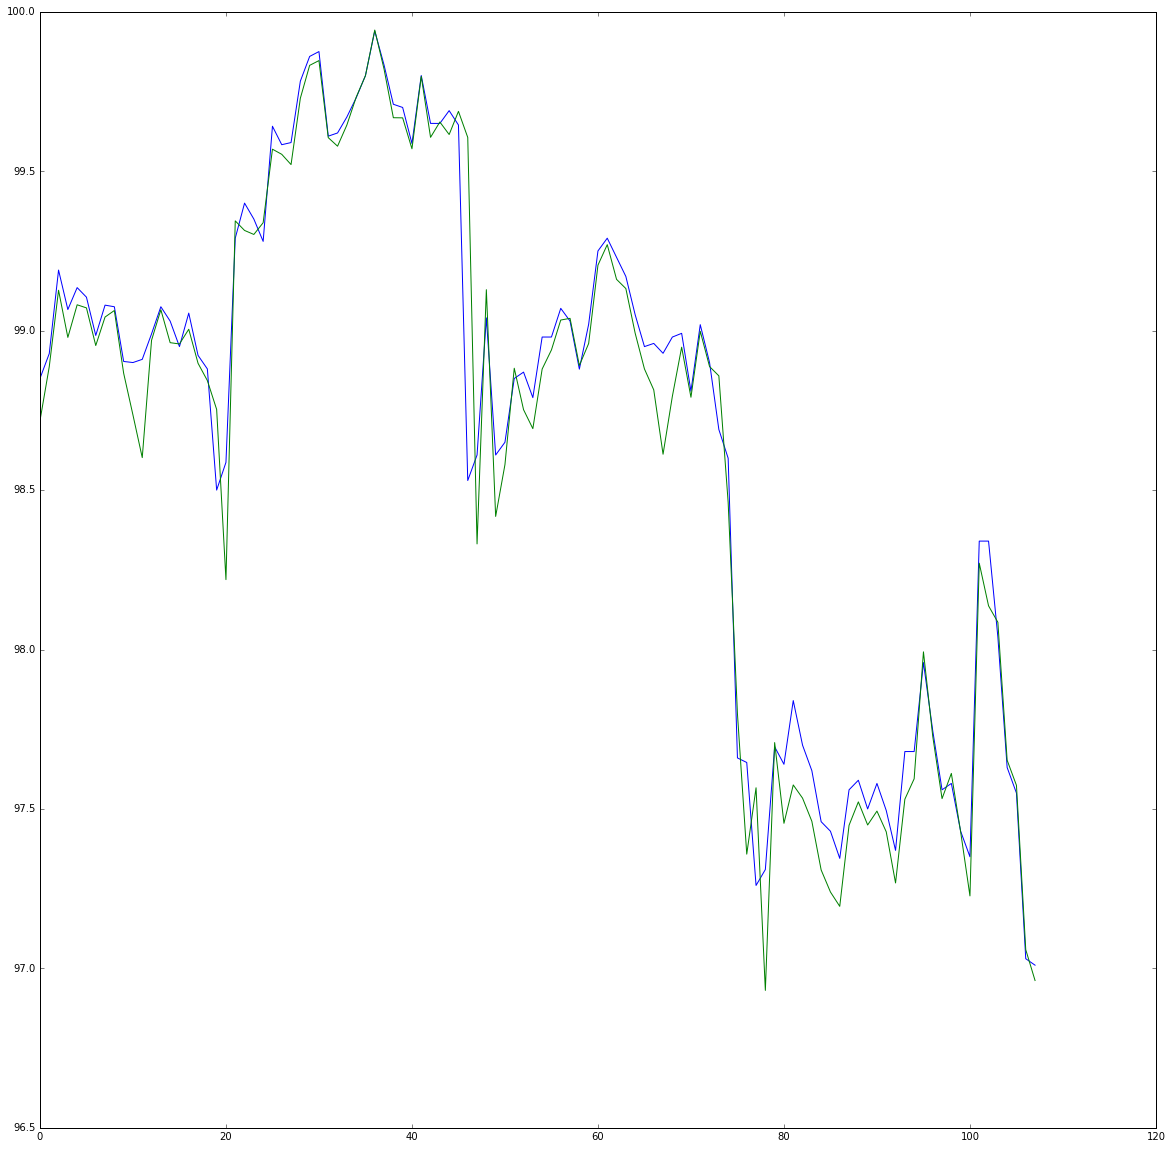

In [57]:
predicted_intra = predict_intra(X_test,y_test, model_intra)
plt.figure(figsize=(20,20))
plt.plot(y_test) 
plt.plot(predicted_intra)
plt.show()

## MAE and RMSE Evaluation

In [58]:
sum_error = 0
sum_error_donothing = 0
for i in range(len(predicted_intra)):
    if i>0:
        sum_error = sum_error + abs(predicted_intra[i] - y_test[i])
        sum_error_donothing = sum_error_donothing + abs(predicted_intra[i] - y_test[i-1])
MAE_lstm = sum_error/len(predicted_intra)
MAE_donothing = sum_error_donothing/len(predicted_intra)
print("MAE for LSTM is: " + str(MAE_lstm))
print("MAE for doing nothing is: " + str(MAE_donothing))

MAE for LSTM is: [0.091961468484759237]
MAE for doing nothing is: [0.16699238882416201]


In [59]:
sum_error = 0
sum_error_donothing = 0
for i in range(len(predicted_intra)):
    if i>0:
        sum_error = sum_error + (predicted_intra[i] - y_test[i])**2
        sum_error_donothing = sum_error_donothing + (predicted_intra[i] - y_test[i-1])**2
        
RMSE_lstm = (sum_error/len(predicted_intra))**(1.0/2.0)
RMSE_donothing = (sum_error_donothing/len(predicted_intra))**(1.0/2.0)
print("RMSE for LSTM is: " + str(RMSE_lstm))
print("RMSE for doing nothing is: " + str(RMSE_donothing))

RMSE for LSTM is: [0.15719269057322682]
RMSE for doing nothing is: [0.23207816758496383]


## Policy Function Evaluation

In [64]:
net_profits = []
protits_per_trade = []
for i in range(50):
    THRESH = i/10000.0
    LOT_SIZE = 100
    net_profit = 0
    num_trades = 0
    for i in range(len(predicted_intra)):
        if i>1:
            predicted_change = ((predicted_intra[i] / y_test[i-1]) - 1)
            #print(predicted_change)
            actual_change = (predicted_intra[i] -  y_test[i])*LOT_SIZE
            if predicted_change >= THRESH:
                #print("Buy")
                net_profit = net_profit + actual_change 
                num_trades = num_trades + 1
            elif predicted_change <= -THRESH:
                #print("Short")
                net_profit = net_profit - actual_change
                num_trades = num_trades + 1
            else:
                #print("Do Nothing")
                pass
    net_profits.append(net_profit)
    protits_per_trade.append(net_profit/float(num_trades))
    print(net_profit,num_trades)


(array([327.67074597699519], dtype=object), 106)
(array([322.81673063817777], dtype=object), 103)
(array([332.06239622235074], dtype=object), 98)
(array([343.15804838923327], dtype=object), 96)
(array([421.84453577845318], dtype=object), 89)
(array([434.17658720982644], dtype=object), 85)
(array([445.90298027279687], dtype=object), 80)
(array([411.04492437555677], dtype=object), 74)
(array([404.36667399665964], dtype=object), 70)
(array([429.47014950372875], dtype=object), 66)
(array([419.1072148767276], dtype=object), 62)
(array([430.23264929397129], dtype=object), 61)
(array([422.19014341311976], dtype=object), 59)
(array([445.82579056646097], dtype=object), 57)
(array([409.84638569643721], dtype=object), 52)
(array([405.67714732624722], dtype=object), 49)
(array([393.17047081189287], dtype=object), 45)
(array([387.45891069212064], dtype=object), 42)
(array([364.92757691648023], dtype=object), 39)
(array([369.39113552225109], dtype=object), 38)
(array([367.09376416912107], dtype=obje

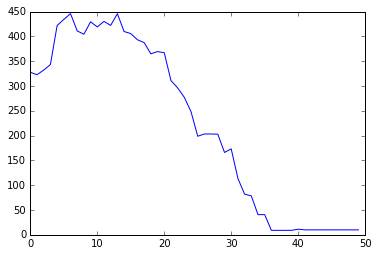

In [65]:
plt.plot(net_profits)
plt.show()

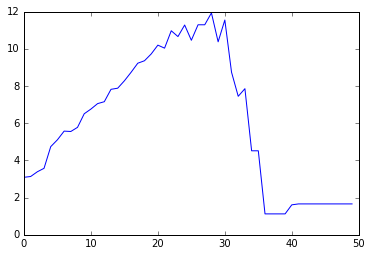

In [66]:
plt.plot(protits_per_trade)
plt.show()

## Other Stuff

In [176]:
buyTotal = 0
sellTotal = 0
correct = 0
sellCorrect = 0
buyCorrect = 0
for i in range(len(predicted_st)):
    realAnswer = y_test_stock[i][0][0]
    if predicted_st[i][1] > predicted_st[i][0]:
        predicted = 0 #Buy
    else:
        predicted = 1 #Sell
        
    if realAnswer == 0:
        ##This is where the actual answer is Buy:Up:[0,1]:0
        buyTotal = buyTotal + 1
        if predicted == realAnswer:
            buyCorrect = buyCorrect + 1
            correct = correct + 1
    else:
        sellTotal = sellTotal + 1 
        if predicted == realAnswer:
            sellCorrect = sellCorrect + 1
            correct = correct + 1
            
percentCorrect = correct/float(len(predicted_st))
buyPercentCorrect = buyCorrect/float(buyTotal)
sellPercentCorrect = sellCorrect/float(sellTotal)

print (correct,len(predicted_st),percentCorrect)
print(buyCorrect,buyTotal, buyPercentCorrect)
print (sellCorrect,sellTotal,sellPercentCorrect)

print (buyTotal/float(len(predicted_st)))
print (sellTotal/float(len(predicted_st)))

(349, 730, 0.4780821917808219)
(210, 382, 0.5497382198952879)
(139, 348, 0.3994252873563218)
0.523287671233
0.476712328767


In [177]:
##Creat training set of all stocks and store their DFs in a list
testing_dataframes = []
END = datetime.today().utcnow()
for industry in sector_tickers.items()[:2]:
    tickers = industry[1]
    for stock in tickers:
        try:
            print (stock)
            df_test = data.DataReader(stock, 'yahoo', datetime(2010,8,1), datetime(2013,8,1))
#             df_test['RSI'] = ta.RSI(df_test.Close.values,timeperiod=14)
#             _,_, macdhist = ta.MACD(df_test.Close.values, fastperiod=12, slowperiod=26, signalperiod=9)
#             df_test['MACDHist'] = macdhist
            y = []
            for i in range(0,len(df_test)):
                if i >= (len(df_test)- STRIDE):
                    y.append(None)
                else:
                    if(df['Close'][i+STRIDE] > df['Close'][i] ):
                        y.append([0,1])
                    else:
                        y.append([1,0])

            df_test['Y_Values'] =np.asarray(y)
            df_test = df_test.ix[:-REWARD_LAG]
            df_test = df_test.dropna()
            sliced_df_test = df_test.drop(['Adj Close','Volume'] ,axis=1)
            testing_dataframes.append((stock,sliced_df_test))
        except:
            pass

MMM
AYI
ALK
ALLE
AAL
AME
APH
BA
CHRW
CAT
CTAS
GLW
CSX
CMI
DHR
DE
DAL
DOV
DNB
ETN
EMR
EXPD
FAST
FDX
FLIR
FLS
FLR
GD
GE
GWW
HON
ITW
IR
IRM
JEC
JBHT
KSU
LLL
LEG
LMT
MAS
NLSN
NSC
NOC
PCAR
PH
PNR
PBI
PWR
RTN
RSG
RHI
ROK
COL
ROP
R
LUV
SRCL
TXT
TYC
UNP
UAL
UPS
URI
UTX
VRSK
WM
XYL
APC
APA
BHI
COG
CHK
CVX
XEC
CPGX
CXO
COP
DVN
DO
EOG
EQT
XOM
FTI
HAL
HP
HES
KMI
MRO
MPC
MUR
NOV
NFX
NBL
OXY
OKE
PSX
PXD
RRC
SLB
SWN
SE
TSO
RIG
VLO
WMB


## Creat Baseline RMSE 

In [178]:
totalCorrect = 0
total = 0
for stock in testing_dataframes[:50]:
    
    X_test_stock, y_test_stock = _load_data_test(stock[1])
    predicted_st = predict_standard(X_test_stock,y_test_stock, model)
    
    buyTotal = 0
    sellTotal = 0
    correct = 0
    sellCorrect = 0
    buyCorrect = 0
    
    for i in range(len(predicted_st)):
        realAnswer = y_test_stock[i][0][0]
        if predicted_st[i][1] > predicted_st[i][0]:
            predicted = 0 #Buy
        else:
            predicted = 1 #Sell

        if realAnswer == 0:
            ##This is where the actual answer is Buy:Up:[0,1]:0
            buyTotal = buyTotal + 1
            if predicted == realAnswer:
                buyCorrect = buyCorrect + 1
                correct = correct + 1
        else:
            sellTotal = sellTotal + 1 
            if predicted == realAnswer:
                sellCorrect = sellCorrect + 1
                correct = correct + 1
            
    percentCorrect = correct/float(len(predicted_st))
    buyPercentCorrect = buyCorrect/float(buyTotal)
    sellPercentCorrect = sellCorrect/float(sellTotal)

    print (correct,len(predicted_st),percentCorrect)
    #print(buyCorrect,buyTotal, buyPercentCorrect)
    #print (sellCorrect,sellTotal,sellPercentCorrect)
    
    totalCorrect = totalCorrect + correct
    total = total + len(predicted_st)

totalPercent = totalCorrect/float(total)
print ("Total percent " + str(totalPercent))


(355, 730, 0.4863013698630137)
(349, 730, 0.4780821917808219)
(388, 730, 0.5315068493150685)
(361, 730, 0.4945205479452055)
(356, 730, 0.4876712328767123)
(363, 730, 0.49726027397260275)
(370, 730, 0.5068493150684932)
(379, 730, 0.5191780821917809)
(370, 730, 0.5068493150684932)
(377, 730, 0.5164383561643836)
(356, 730, 0.4876712328767123)
(358, 730, 0.4904109589041096)
(377, 730, 0.5164383561643836)
(363, 730, 0.49726027397260275)
(362, 730, 0.4958904109589041)
(357, 730, 0.48904109589041095)
(364, 730, 0.4986301369863014)
(377, 730, 0.5164383561643836)
(375, 730, 0.5136986301369864)
(349, 730, 0.4780821917808219)
(368, 730, 0.5041095890410959)
(359, 730, 0.4917808219178082)
(384, 730, 0.5260273972602739)
(376, 730, 0.5150684931506849)
(364, 730, 0.4986301369863014)
(352, 730, 0.4821917808219178)
(366, 730, 0.5013698630136987)
(389, 730, 0.5328767123287671)
(379, 730, 0.5191780821917809)
(382, 730, 0.5232876712328767)
(378, 730, 0.5178082191780822)
(374, 730, 0.5123287671232877)
(362,

## Precision and F1-Score Evaluation

In [22]:
#Run your test set through the standard model
predicted_st = predict_change(X_test_stock,y_test_stock, model_3)
print (len(predicted_st))
print (predicted_st)

235
[array([ 0.22849986,  0.77150011]), array([ 0.28702384,  0.71297616]), array([ 0.2421869,  0.7578131]), array([ 0.27497175,  0.72502828]), array([ 0.24673952,  0.75326049]), array([ 0.25445694,  0.74554306]), array([ 0.26823467,  0.73176533]), array([ 0.23660263,  0.7633974 ]), array([ 0.28320026,  0.71679968]), array([ 0.25575349,  0.74424654]), array([ 0.27164406,  0.72835594]), array([ 0.23602955,  0.76397043]), array([ 0.26221129,  0.73778868]), array([ 0.2551769,  0.7448231]), array([ 0.24834478,  0.75165528]), array([ 0.25639099,  0.74360895]), array([ 0.23785527,  0.76214474]), array([ 0.27466008,  0.72533989]), array([ 0.22693937,  0.77306068]), array([ 0.26071233,  0.73928767]), array([ 0.25766575,  0.74233425]), array([ 0.22035766,  0.77964228]), array([ 0.28408512,  0.71591491]), array([ 0.2200489,  0.7799511]), array([ 0.27364326,  0.72635674]), array([ 0.23427884,  0.7657212 ]), array([ 0.24048358,  0.75951642]), array([ 0.27664059,  0.72335941]), array([ 0.21227749,  

In [255]:
#Run your test set through the bidirectional model
predicted_bi = predict_change(X_test_merged,y_test_merged, bimodel)
print (len(predicted_bi))

14200


In [21]:
#Count the number of positive and the number of negative calls you got right
totalCorrect = 0
total = 0
buyTotal = 0
sellTotal = 0
correct = 0
sellCorrect = 0
buyCorrect = 0
    
for i in range(len(predicted_st)):
    realAnswer = y_test_stock[i][0][0]
    if predicted_st[i][1] > predicted_st[i][0]:
        predicted = 0 #Buy
    else:
        predicted = 1 #Sell

    if realAnswer == 0:
        ##This is where the actual answer is Buy:Up:[0,1]:0
        buyTotal = buyTotal + 1
        if predicted == realAnswer:
            buyCorrect = buyCorrect + 1
            correct = correct + 1
    else:
        sellTotal = sellTotal + 1 
        if predicted == realAnswer:
            sellCorrect = sellCorrect + 1
            correct = correct + 1
            
percentCorrect = correct/float(len(predicted_st))
buyPercentCorrect = buyCorrect/float(buyTotal)
sellPercentCorrect = sellCorrect/float(sellTotal)

print (correct,len(predicted_st),percentCorrect)
print(buyCorrect,buyTotal, buyPercentCorrect)
print (sellCorrect,sellTotal,sellPercentCorrect)
print(buyTotal/float(len(predicted_st)))
print(sellTotal/float(len(predicted_st)))

(104, 235, 0.4425531914893617)
(104, 104, 1.0)
(0, 131, 0.0)
0.442553191489
0.557446808511


In [77]:
from sklearn.metrics import f1_score
##Calculate F1 score
actual = []
result = []
for y in y_test_merged:
    if y[0] == 0:
        actual.append(0)
    else:
        actual.append(1)
for y in predicted_st:
    if y[1] > y[0]:
        result.append(0)
    else:
        result.append(1)
score = f1_score(actual,result,average='weighted',pos_label=1)
print(score)

0.498192044998


/home/ai2-jedi/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)


In [78]:
#Same percentage calculations but with a threshold
THRESH = 0.1

totalCorrect = 0
total = 0
noDecision = 0
buyTotal = 0
sellTotal = 0
correct = 0
sellCorrect = 0
buyCorrect = 0
    
for i in range(len(predicted_st)):
    realAnswer = y_test_merged[i][0]
    if predicted_st[i][1] - THRESH > .5:
        predicted = 0 #Buy
    elif predicted_st[i][0] - THRESH > .5:
        predicted = 1 #Sell
    else:
        predicted = 2 #Pass, do not count towards percentages because you make no decision if .6>x>.4

    if predicted == 2:
        noDecision = noDecision + 1
    else:
        total = total + 1
        if realAnswer == 0:
            ##This is where the actual answer is Buy:Up:[0,1]:0
            buyTotal = buyTotal + 1
            if predicted == realAnswer:
                buyCorrect = buyCorrect + 1
                correct = correct + 1
        else:
            sellTotal = sellTotal + 1 
            if predicted == realAnswer:
                sellCorrect = sellCorrect + 1
                correct = correct + 1
            
percentCorrect = correct/float(total)
buyPercentCorrect = buyCorrect/float(buyTotal)
sellPercentCorrect = sellCorrect/float(sellTotal)

print (correct,total,percentCorrect)
print(buyCorrect,buyTotal, buyPercentCorrect)
print (sellCorrect,sellTotal,sellPercentCorrect)

print("If you just predicted all Up " + str(buyTotal/float(total)))
print("If you just predicted all Down " + str(sellTotal/float(total)))

(347, 750, 0.46266666666666667)
(190, 351, 0.5413105413105413)
(157, 399, 0.39348370927318294)
If you just predicted all Up 0.468
If you just predicted all Down 0.532


In [79]:
thresholds = []
totalAcc = []
positiveAcc = []
negativeAcc = []
##Graph this graph of the threshold vs accuracy
for i in range(10):
    thresh = i/100.0
    totalCorrect = 0
    total = 0
    noDecision = 0
    buyTotal = 0
    sellTotal = 0
    correct = 0
    sellCorrect = 0
    buyCorrect = 0
    for i in range(len(predicted_st)):
        realAnswer = y_test_merged[i][0]
        if predicted_st[i][1] - thresh > .5:
            predicted = 0 #Buy
        elif predicted_st[i][0] - thresh > .5:
            predicted = 1 #Sell
        else:
            predicted = 2 #Pass, do not count towards percentages because you make no decision if .6>x>.4

        if predicted == 2:
            noDecision = noDecision + 1
        else:
            total = total + 1
            if realAnswer == 0:
                ##This is where the actual answer is Buy:Up:[0,1]:0
                buyTotal = buyTotal + 1
                if predicted == realAnswer:
                    buyCorrect = buyCorrect + 1
                    correct = correct + 1
            else:
                sellTotal = sellTotal + 1 
                if predicted == realAnswer:
                    sellCorrect = sellCorrect + 1
                    correct = correct + 1

    percentCorrect = correct/float(total)
    buyPercentCorrect = buyCorrect/float(buyTotal)
    sellPercentCorrect = sellCorrect/float(sellTotal)
    thresholds.append(thresh)
    totalAcc.append(percentCorrect)
    positiveAcc.append(buyPercentCorrect)
    negativeAcc.append(sellPercentCorrect)

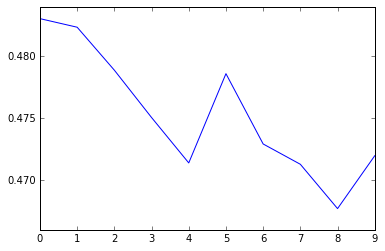

In [80]:
plt.plot(totalAcc)
plt.show()

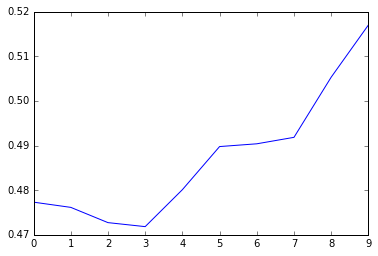

In [81]:
plt.plot(positiveAcc)
plt.show()

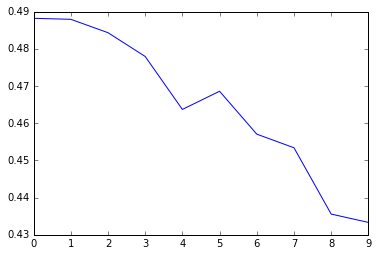

In [82]:
plt.plot(negativeAcc)
plt.show()